In [1]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python3)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: build: File exists
-- The C compiler identification is AppleClang 11.0.3.11030032
-- The CXX compiler identification is AppleClang 11.0.3.11030032
-- Check for working C compiler: /Library/Developer/CommandLineTools/usr/bin/cc
-- Check for working C compiler: /Library/Developer/CommandLineTools/usr/bin/cc - works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /Library/Developer/CommandLineTools/usr/bin/c++
-- Check for working CXX compiler: /Library/Developer/CommandLineTools/usr/bin/c++ - works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /usr/local/bin/python3 (found version "3.7.7") 
-- Found PythonLibs: /usr/local/opt/python/Frameworks/Python.framework/Versions/3.7/lib/libpython3.7m.dylib
-- pybind11 v2.5

In [1]:
import math 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from mpl_toolkits import mplot3d
from sklearn.linear_model import LinearRegression

In [2]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum

/Users/mariano.benzo/Facultad/Metodos/TP3/metnum-tp3/notebooks
Python 2.7.16


## Linear Regression Predict

In [3]:
def linearRegressorPredict(df_train, df_test, cs, cPred):
    x = df_train[cs].values
    y = df_train[cPred].values
    x = x.reshape(len(x), x.shape[1])
    y = y.reshape(len(y), 1)

    linear_regressor = metnum.LinearRegression()
    linear_regressor.fit(x,y)

    x = df_test[cs].values
    x = x.reshape(len(x), x.shape[1])
    
    df_test[cPred] = linear_regressor.predict(x)
    
    df_test = df_test[df_test[cPred] < 0].dropna()


## K-Fold Cross-Validation

In [4]:
def splitTrainSet(x, y, K, i):
    size = int(x.shape[0] * 1/K)
    
    x_train1 = x[:i * size]
    x_train2 = x[(i + 1) * size:]
    x_train = np.concatenate((x_train1, x_train2))
    x_test = x[i * size:(i + 1) * size]
    
    y_train1 = y[:i * size]
    y_train2 = y[(i + 1) * size:]
    y_train = np.concatenate((y_train1, y_train2))
    y_test = y[i * size:(i + 1) * size]
    
    return x_train, y_train, x_test, y_test

In [5]:
from sklearn.linear_model import LinearRegression

def linearRegressionKFoldErrors(df_train, cs, cPred, K):
    
    x = df_train[cs].values
    y = df_train[cPred].values
    x = x.reshape(len(x), x.shape[1])
    y = y.reshape(len(y), 1)

    RMSE = []
    RMSLE = []
    
    for i in range(0, K):
        x_train, y_train, x_test, y_test = splitTrainSet(x, y, K, i)
                
        linear_regressor = metnum.LinearRegression()

        linear_regressor.fit(x_train, y_train)
        
        y_pred = linear_regressor.predict(x_test)
        
        y_test, y_pred = deleteNegativeElements(y_test, y_pred)
            
        e = linearRegressorRMSE(y_test, y_pred)
        le = linearRegressorRMSLE(y_test, y_pred)

        RMSE.append(e)
        RMSLE.append(le)

    RMSE = np.mean(RMSE)
    RMSLE = np.mean(RMSLE)

    return RMSE, RMSLE

In [6]:
def deleteNegativeElements(y_test, y_pred):
    negativeIndex = []
    for i in range(0, len(y_pred)):
        if (y_pred[i] < 0 or y_test[i] < 0):
            negativeIndex.append(i)

    y_pred = [i for j, i in enumerate(y_pred) if j not in negativeIndex]
    y_test = [i for j, i in enumerate(y_test) if j not in negativeIndex]
            
    return y_test, y_pred

## RMSE & RMSLE

In [7]:
def linearRegressorRMSE(y_test, y_pred):
    n = len(y_test)
    return math.sqrt(sum([(y_test[i] - y_pred[i])**2 for i in range(0, n)]) / n)

In [8]:
def linearRegressorRMSLE(y_test, y_pred):
    n = len(y_test)    
    return math.sqrt(sum([(math.log(y_test[i] + 1) - (math.log(y_pred[i] + 1)))**2 for i in range(0, n)]) / n)

## Figures 2D & 3D

In [9]:
def linearRegressorFigure2D(df_train, df_test, c1, cPred):
    sns.scatterplot(data=df_train, x=c1, y=cPred)
    sns.lineplot(data=df_test, x=c1, y=cPred, color='red')

In [10]:
def linearRegressorFigure3D(df_train, df_test, c1, c2, cPred):
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    xline = df_test[c1].values
    yline = df_test[c2].values
    zline = df_test[cPred].values
    ax.plot_trisurf(xline, yline, zline, color='red', alpha=0.5)

    xdata = df_train[c1].values
    ydata = df_train[c2].values
    zdata = df_train[cPred].values
    ax.scatter3D(xdata, ydata, zdata, edgecolors='blue')

    ax.set_xlabel(c1)
    ax.set_ylabel(c2)
    ax.set_zlabel(cPred)

## Experimentacion

### Test 1

In [11]:
df_train = pd.read_csv('../data/train.csv')
df_train = df_train[df_train['provincia']=='Jalisco'].dropna()
df_train = df_train[(df_train['tipodepropiedad']=='Casa') | (df_train['tipodepropiedad']=='Apartamento')].dropna()

In [13]:
K = 5
RMSE, RMSLE = linearRegressionKFoldErrors(df_train, ['metroscubiertos', 'metrostotales'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)

RMSE:  958108.7094075375
RMSLE:  0.4260875324610639


In [14]:
n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

In [15]:
linearRegressorPredict(df_train, df_test, ['metroscubiertos', 'metrostotales'], 'precio')

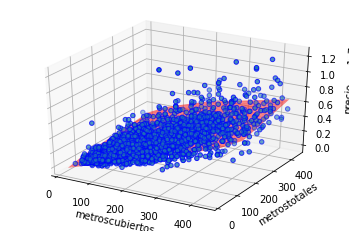

In [16]:
linearRegressorFigure3D(df_train, df_test, 'metroscubiertos', 'metrostotales', 'precio')

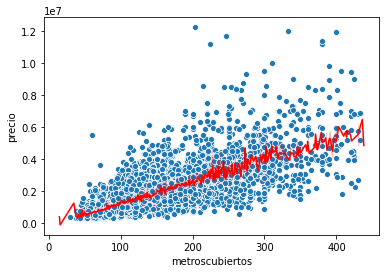

In [17]:
linearRegressorFigure2D(df_train, df_test, 'metroscubiertos', 'precio')

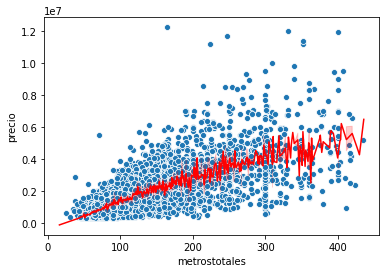

In [18]:
linearRegressorFigure2D(df_train, df_test, 'metrostotales', 'precio')

### Test 2

In [19]:
df_train = pd.read_csv('../data/train.csv')
df_train = df_train[df_train['provincia']=='Jalisco'].dropna()
df_train = df_train[(df_train['tipodepropiedad']=='Casa') | (df_train['tipodepropiedad']=='Apartamento')].dropna()

In [21]:
K = 5
RMSE, RMSLE = linearRegressionKFoldErrors(df_train, ['habitaciones', 'banos', 'piscina', 'garages'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)

RMSE:  1119461.0259976636
RMSLE:  0.6079483832072047


In [22]:
n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

In [23]:
linearRegressorPredict(df_train, df_test, ['habitaciones', 'banos', 'piscina', 'garages'], 'precio')

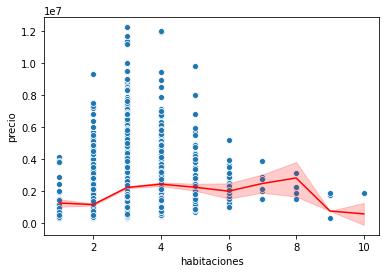

In [24]:
linearRegressorFigure2D(df_train, df_test, 'habitaciones', 'precio')

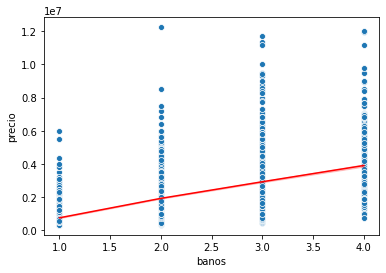

In [25]:
linearRegressorFigure2D(df_train, df_test, 'banos', 'precio')

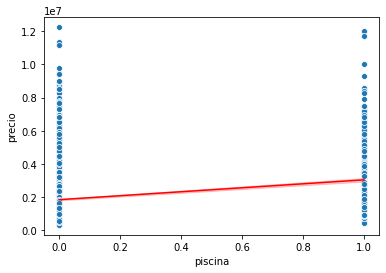

In [26]:
linearRegressorFigure2D(df_train, df_test, 'piscina', 'precio')

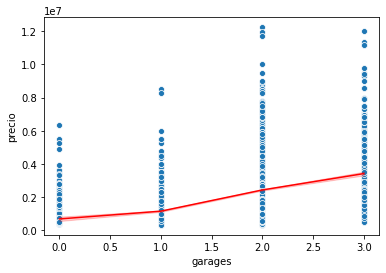

In [27]:
linearRegressorFigure2D(df_train, df_test, 'garages', 'precio')

### Test 3

In [108]:
df_train = pd.read_csv('../data/train.csv')
df_train = df_train[df_train['provincia']=='Jalisco'].dropna()
df_train = df_train[(df_train['tipodepropiedad']=='Casa') | (df_train['tipodepropiedad']=='Apartamento')].dropna()
df_train = df_train[(df_train['lng']>-105.30) & (df_train['lng']<-105.18)].dropna()
df_train = df_train[(df_train['lat']>20.5) & (df_train['lat']<20.8)].dropna()
#df_train = df_train[(df_train['lng']>-130.0) & (df_train['lng']<-80.0)].dropna()
#df_train = df_train[(df_train['lat']>5.0) & (df_train['lat']<50.0)].dropna()

In [109]:
K = 5
RMSE, RMSLE = linearRegressionKFoldErrors(df_train, ['lat', 'lng', 'centroscomercialescercanos', 'escuelascercanas'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)

RMSE:  1296805.8413740597
RMSLE:  0.8383096073562635


In [110]:
n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

In [111]:
linearRegressorPredict(df_train, df_test, ['lat', 'lng', 'centroscomercialescercanos', 'escuelascercanas'], 'precio')

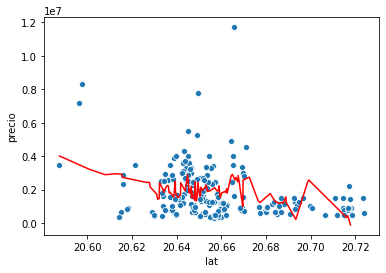

In [104]:
linearRegressorFigure2D(df_train, df_test, 'lat', 'precio')

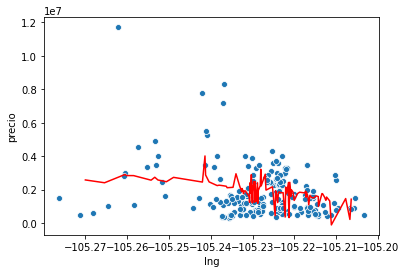

In [105]:
linearRegressorFigure2D(df_train, df_test, 'lng', 'precio')

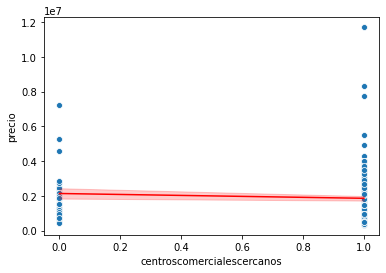

In [106]:
linearRegressorFigure2D(df_train, df_test, 'centroscomercialescercanos', 'precio')

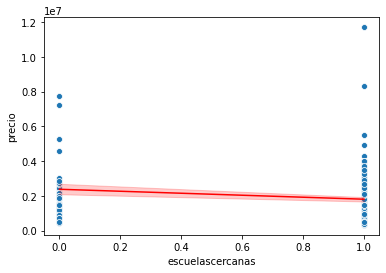

In [107]:
linearRegressorFigure2D(df_train, df_test, 'escuelascercanas', 'precio')

### Test 4

In [112]:
df_train = pd.read_csv('../data/train.csv')
df_train = df_train[df_train['provincia']=='Distrito Federal'].dropna()
df_train = df_train[(df_train['tipodepropiedad']=='Casa') | (df_train['tipodepropiedad']=='Apartamento')].dropna()

In [113]:
K = 5
RMSE, RMSLE = linearRegressionKFoldErrors(df_train, ['antiguedad'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)

RMSE:  2165244.2293468225
RMSLE:  0.767279771443773


In [114]:
n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

In [115]:
linearRegressorPredict(df_train, df_test, ['antiguedad'], 'precio')

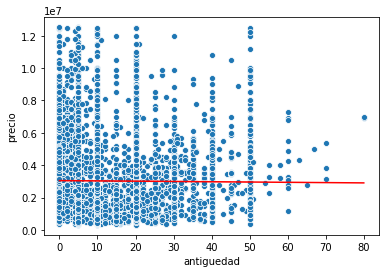

In [116]:
linearRegressorFigure2D(df_train, df_test, 'antiguedad', 'precio')

In [187]:
df_train = pd.read_csv('../data/train.csv')
df_train = df_train[df_train['provincia']=='Distrito Federal'].dropna()
df_train = df_train[(df_train['tipodepropiedad']=='Casa') | (df_train['tipodepropiedad']=='Apartamento')].dropna()
df_train = df_train[df_train['antiguedad'] <= 20].dropna()

In [188]:
K = 5
RMSE, RMSLE = linearRegressionKFoldErrors(df_train, ['antiguedad'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)

RMSE:  2169767.7243556334
RMSLE:  0.7703683636503728


In [189]:
n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

In [190]:
linearRegressorPredict(df_train, df_test, ['antiguedad'], 'precio')

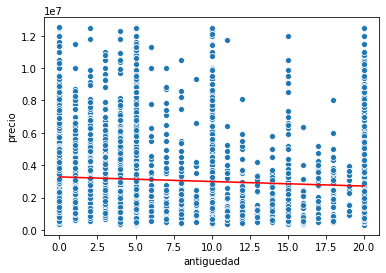

In [191]:
linearRegressorFigure2D(df_train, df_test, 'antiguedad', 'precio')

In [192]:
df_train = pd.read_csv('../data/train.csv')
df_train = df_train[df_train['provincia']=='Distrito Federal'].dropna()
df_train = df_train[(df_train['tipodepropiedad']=='Casa') | (df_train['tipodepropiedad']=='Apartamento')].dropna()
df_train = df_train[df_train['antiguedad'] > 20].dropna()

In [193]:
K = 5
RMSE, RMSLE = linearRegressionKFoldErrors(df_train, ['antiguedad'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)

RMSE:  1963763.1381670285
RMSLE:  0.6708342869580823


In [194]:
n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

In [195]:
linearRegressorPredict(df_train, df_test, ['antiguedad'], 'precio')

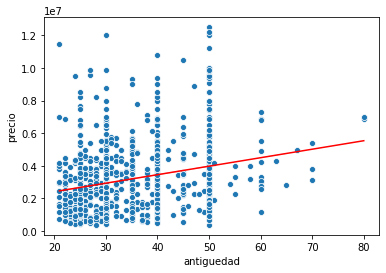

In [196]:
linearRegressorFigure2D(df_train, df_test, 'antiguedad', 'precio')

### Test 5

In [150]:
df_train = pd.read_csv('../data/train.csv')
df_train = df_train[df_train['provincia']=='Distrito Federal'].dropna()
df_train = df_train[df_train['tipodepropiedad']=='Casa'].dropna()
df_train['patio'] = df_train['metrostotales'] - df_train['metroscubiertos']
df_train = df_train[df_train['patio'] >= 0].dropna()

In [151]:
K = 5
RMSE, RMSLE = linearRegressionKFoldErrors(df_train, ['patio'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)

RMSE:  2013575.262149458
RMSLE:  0.6566774476977175


In [152]:
n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

In [153]:
linearRegressorPredict(df_train, df_test, ['patio'], 'precio')

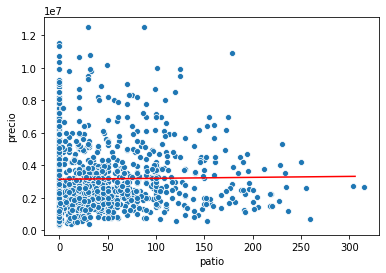

In [155]:
linearRegressorFigure2D(df_train, df_test, 'patio', 'precio')

In [156]:
df_train = pd.read_csv('../data/train.csv')
df_train = df_train[df_train['provincia']=='Jalisco'].dropna()
df_train = df_train[df_train['tipodepropiedad']=='Casa'].dropna()
df_train['patio'] = df_train['metrostotales'] - df_train['metroscubiertos']
df_train = df_train[df_train['patio'] >= 0].dropna()

In [157]:
K = 5
RMSE, RMSLE = linearRegressionKFoldErrors(df_train, ['patio'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)

RMSE:  1314641.5571591756
RMSLE:  0.7879546232123209


In [158]:
n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

In [159]:
linearRegressorPredict(df_train, df_test, ['patio'], 'precio')

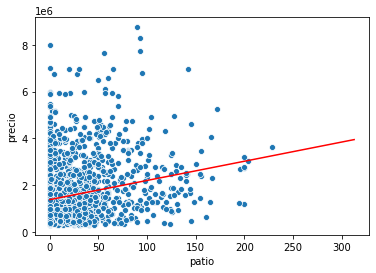

In [161]:
linearRegressorFigure2D(df_train, df_test, 'patio', 'precio')

### Test 6


In [181]:
df_train = pd.read_csv('../data/train.csv')
df_train = df_train[(df_train['tipodepropiedad']=='Casa') | (df_train['tipodepropiedad']=='Apartamento')].dropna()

provincia_info = {
    'provincia':["Aguascalientes", "Baja California Norte", "Baja California Sur", "Campeche", "Coahuila", "Colima", "Chiapas", "Chihuahua", "Distrito Federal", "Durango", "Guanajuato", "Guerrero", "Hidalgo", "Jalisco", "Edo. de México", "Michoacán", "Morelos", "Nayarit", "Nuevo León", "Oaxaca", "Puebla", "Querétaro", "Quintana Roo", "San luis Potosí", "Sinaloa", "Sonora", "Tabasco", "Tamaulipas", "Tlaxcala", "Veracruz", "Yucatán", "Zacatecas"],
    'densidadpoblacional':[233.7, 46.4, 9.6, 15.6, 19.5, 126.4, 71.2, 14.4, 5967.3, 14.2, 191.3, 55.6, 137.3, 99.8, 724.2, 78.2, 390.2, 42.4, 79.8, 42.3, 179.8, 174.4, 33.6, 44.5, 51.7, 15.9, 96.9, 42.9, 318.4, 113.0, 53.1, 21.0],
    'criminalidad': [35.457, 32.758, 25.577, 22.114, 24.800, 27.045, 16.687, 31.274, 52.718, 25.640, 33.154, 53.875, 21.159, 49.317, 56.835, 23.876, 43.419, 21.288, 26.221, 24.961, 27.530, 30.991, 35.639, 25.838, 22.750, 40.466, 30.409, 21.363, 30.699, 22.157, 25.862, 21.501]
}

df_provincia_info = pd.DataFrame(provincia_info, columns = ['provincia', 'densidadpoblacional', 'criminalidad'])

df_train = pd.merge(df_train, df_provincia_info, on = "provincia")

df_train = df_train.sample(frac=1)

df_train = df_train[df_train['densidadpoblacional']<400].dropna()

In [182]:
K = 5
RMSE, RMSLE = linearRegressionKFoldErrors(df_train, ['densidadpoblacional', 'criminalidad'], 'precio', K)
print('RMSE: ', RMSE)
print('RMSLE: ', RMSLE)

RMSE:  1339857.8767756256
RMSLE:  0.780598709209303


In [183]:
n = int(len(df_train)/3)
df_test = df_train[:n]
df_train = df_train[n:]

In [184]:
linearRegressorPredict(df_train, df_test, ['densidadpoblacional', 'criminalidad'], 'precio')

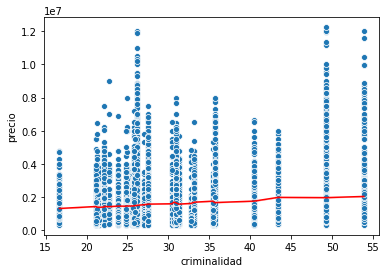

In [185]:
linearRegressorFigure2D(df_train, df_test, 'criminalidad', 'precio')

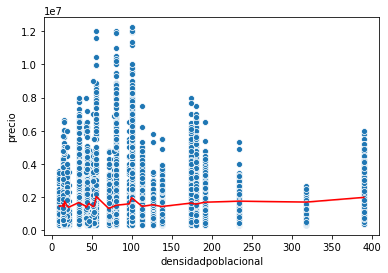

In [186]:
linearRegressorFigure2D(df_train, df_test, 'densidadpoblacional', 'precio')